In [310]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import scipy.io

# Importing Preprocessed Data

In [311]:
path = os.getcwd() 
filename = path+'/TrainSet0501.csv'
trainSet = pd.read_csv(filename)
filename = path+'/TestSet0501.csv'
testSet = pd.read_csv(filename)

# Defining Labels

In [312]:
Labels = ['death30', 'death60', 'death90', 'ICU', 'vent', 'anyCatastrophic','Admit30Days', 
          'Admit60Days', 'Admit90Days', 'Admit7Days','Admit14Days']

## Separating features (X) from labels (y)

In [313]:
y_train = trainSet[Labels]
y_train = y_train.astype(int)
X_train = trainSet.drop(Labels,axis=1)
y_test = testSet[Labels]
y_test = y_test.astype(int)
X_test = testSet.drop(Labels,axis=1)

In [314]:
#number of features
n_features = len(X_train.columns)

## Focusing on one label to be predicted

In [315]:
labelName = Labels[5]
labelTrain = y_train.loc[:,labelName]
labelTest= y_test.loc[:,labelName]
#display(labelTrain.value_counts())
print(f'Predicting label: {labelName}')

Predicting label: anyCatastrophic


## Defining Neural Network Architecture

In [345]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras

#Define the optimizer parameters, we tried several learning rates and these parameters gave the best results
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

# define the model
#Our neural network has two hidden layers with variable number of neurons
#The activation function was tested with sigmoid, tanh and relu. Relu gave the best results
#We set a lasso regularizer to avoid overfitting as well as two dropout layers
#Dropout rate was changed manually
def create_model(n_neuronsL1,n_neuronsL2):
    model = Sequential()
    model.add(Dense(n_neuronsL1, activation='relu', kernel_initializer='lecun_uniform',kernel_regularizer='l1',
                    input_shape=(n_features,)))
    model.add(Dropout(0.2))
    model.add(Dense(n_neuronsL2, activation='relu', kernel_initializer='lecun_uniform',kernel_regularizer='l1'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='binary_accuracy')
    return model

#The number of epochs and batchsize were set by manual search
modelNN = KerasClassifier(build_fn=create_model, epochs=1000, batch_size=500, initial_epoch=0, verbose=1)

# Defining parameter grid for optimization

In [346]:
# define the grid search parameters
neuronsL1 = range(10,20,2)
neuronsL2 = range(2,10,2)

param_grid = {'kerasclassifier__n_neuronsL1':neuronsL1,'kerasclassifier__n_neuronsL2':neuronsL2}


In [347]:
#This callback is not being used in the final version
#from tensorflow import keras
#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

## Defining training pipeline

In [348]:
#We define a pipeline to upsample the minority class on each training split of the crossvalidation
#We upsample with a random sampler which copies random samples from the minority class
#Then we pass the neural network model

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler

pipeline_grid = make_pipeline(
    RandomOverSampler(random_state=0),
    modelNN,
)

# Training model

In [349]:
#We perform a gridsearch over the hyperparameter grid defined above (number of neurons of layer 1 and 2)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, matthews_corrcoef, f1_score

scorer_mcc = make_scorer(matthews_corrcoef,greater_is_better=True)
scoring = {'F1': 'f1', 'MCC': scorer_mcc}

#Create cross-validation object for stratified splits
kfold = StratifiedKFold(n_splits=5, shuffle=True)

#Perform gridsearch and score models based on f1 metric
grid = GridSearchCV(pipeline_grid, param_grid=param_grid, n_jobs=-1,cv=kfold,scoring=scoring,refit = 'MCC',verbose=3)
grid_result = grid.fit(X_train, labelTrain)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Epoch 1/1000
50/50 [==============================] - 1s 1ms/step - loss: 1.6772 - binary_accuracy: 0.4905
Epoch 2/1000
50/50 [==============================] - 0s 1ms/step - loss: 1.2338 - binary_accuracy: 0.4965
Epoch 3/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.9254 - binary_accuracy: 0.5081
Epoch 4/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.7552 - binary_accuracy: 0.5751
Epoch 5/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.7107 - binary_accuracy: 0.5750
Epoch 6/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.7034 - binary_accuracy: 0.5769
Epoch 7/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6983 - binary_accuracy: 0.5726
Epoch 8/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6946 - binary_accuracy: 0.5865
Epoch 9/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6922 -

50/50 [==============================] - 0s 1ms/step - loss: 0.6245 - binary_accuracy: 0.7097
Epoch 77/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6167 - binary_accuracy: 0.7158
Epoch 78/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6235 - binary_accuracy: 0.7103
Epoch 79/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6219 - binary_accuracy: 0.7126
Epoch 80/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6178 - binary_accuracy: 0.7143
Epoch 81/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6213 - binary_accuracy: 0.7142
Epoch 82/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6200 - binary_accuracy: 0.7114
Epoch 83/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6223 - binary_accuracy: 0.7101
Epoch 84/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6182 - binary_accuracy: 0.7116
Epoch 85/1000
50/50 [=====================

50/50 [==============================] - 0s 1ms/step - loss: 0.6094 - binary_accuracy: 0.7164
Epoch 152/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6140 - binary_accuracy: 0.7107
Epoch 153/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6135 - binary_accuracy: 0.7138
Epoch 154/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6083 - binary_accuracy: 0.7160
Epoch 155/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6136 - binary_accuracy: 0.7140
Epoch 156/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6119 - binary_accuracy: 0.7133
Epoch 157/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6124 - binary_accuracy: 0.7154
Epoch 158/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6150 - binary_accuracy: 0.7111
Epoch 159/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6117 - binary_accuracy: 0.7135
Epoch 160/1000
50/50 [============

50/50 [==============================] - 0s 1ms/step - loss: 0.6090 - binary_accuracy: 0.7156
Epoch 227/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6104 - binary_accuracy: 0.7147
Epoch 228/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6073 - binary_accuracy: 0.7177
Epoch 229/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6053 - binary_accuracy: 0.7176
Epoch 230/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6083 - binary_accuracy: 0.7176
Epoch 231/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6061 - binary_accuracy: 0.7190
Epoch 232/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6060 - binary_accuracy: 0.7186
Epoch 233/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6029 - binary_accuracy: 0.7195
Epoch 234/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6111 - binary_accuracy: 0.7149
Epoch 235/1000
50/50 [============

50/50 [==============================] - 0s 1ms/step - loss: 0.6001 - binary_accuracy: 0.7192
Epoch 302/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6037 - binary_accuracy: 0.7207
Epoch 303/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6072 - binary_accuracy: 0.7133
Epoch 304/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6048 - binary_accuracy: 0.7144
Epoch 305/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6007 - binary_accuracy: 0.7192
Epoch 306/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5986 - binary_accuracy: 0.7239
Epoch 307/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6026 - binary_accuracy: 0.7217
Epoch 308/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5968 - binary_accuracy: 0.7237
Epoch 309/1000
50/50 [==============================] - 0s 2ms/step - loss: 0.6065 - binary_accuracy: 0.7150
Epoch 310/1000
50/50 [============

50/50 [==============================] - 0s 1ms/step - loss: 0.6013 - binary_accuracy: 0.7192
Epoch 377/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6037 - binary_accuracy: 0.7160
Epoch 378/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6027 - binary_accuracy: 0.7168
Epoch 379/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6008 - binary_accuracy: 0.7190
Epoch 380/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5948 - binary_accuracy: 0.7258
Epoch 381/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5955 - binary_accuracy: 0.7266
Epoch 382/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5988 - binary_accuracy: 0.7234
Epoch 383/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5995 - binary_accuracy: 0.7204
Epoch 384/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6012 - binary_accuracy: 0.7212
Epoch 385/1000
50/50 [============

50/50 [==============================] - 0s 1ms/step - loss: 0.5962 - binary_accuracy: 0.7204
Epoch 452/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5975 - binary_accuracy: 0.7213
Epoch 453/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5981 - binary_accuracy: 0.7200
Epoch 454/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6012 - binary_accuracy: 0.7167
Epoch 455/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6061 - binary_accuracy: 0.7145
Epoch 456/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6012 - binary_accuracy: 0.7189
Epoch 457/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5981 - binary_accuracy: 0.7195
Epoch 458/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5972 - binary_accuracy: 0.7232
Epoch 459/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5991 - binary_accuracy: 0.7191
Epoch 460/1000
50/50 [============

50/50 [==============================] - 0s 1ms/step - loss: 0.5953 - binary_accuracy: 0.7235
Epoch 527/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5910 - binary_accuracy: 0.7250
Epoch 528/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5926 - binary_accuracy: 0.7254
Epoch 529/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5929 - binary_accuracy: 0.7225
Epoch 530/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6005 - binary_accuracy: 0.7175
Epoch 531/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5979 - binary_accuracy: 0.7210
Epoch 532/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5877 - binary_accuracy: 0.7290
Epoch 533/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5950 - binary_accuracy: 0.7234
Epoch 534/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5978 - binary_accuracy: 0.7200
Epoch 535/1000
50/50 [============

50/50 [==============================] - 0s 1ms/step - loss: 0.5976 - binary_accuracy: 0.7208
Epoch 602/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6003 - binary_accuracy: 0.7191
Epoch 603/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5972 - binary_accuracy: 0.7180
Epoch 604/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5982 - binary_accuracy: 0.7220
Epoch 605/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5989 - binary_accuracy: 0.7174
Epoch 606/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5962 - binary_accuracy: 0.7197
Epoch 607/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5951 - binary_accuracy: 0.7218
Epoch 608/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5945 - binary_accuracy: 0.7248
Epoch 609/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5933 - binary_accuracy: 0.7205
Epoch 610/1000
50/50 [============

50/50 [==============================] - 0s 1ms/step - loss: 0.5916 - binary_accuracy: 0.7238
Epoch 677/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6008 - binary_accuracy: 0.7165
Epoch 678/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5908 - binary_accuracy: 0.7240
Epoch 679/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5950 - binary_accuracy: 0.7195
Epoch 680/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5949 - binary_accuracy: 0.7213
Epoch 681/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5896 - binary_accuracy: 0.7264
Epoch 682/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5962 - binary_accuracy: 0.7206
Epoch 683/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5974 - binary_accuracy: 0.7204
Epoch 684/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5954 - binary_accuracy: 0.7196
Epoch 685/1000
50/50 [============

50/50 [==============================] - 0s 1ms/step - loss: 0.5869 - binary_accuracy: 0.7305
Epoch 752/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5906 - binary_accuracy: 0.7229
Epoch 753/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5887 - binary_accuracy: 0.7239
Epoch 754/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5902 - binary_accuracy: 0.7261
Epoch 755/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5924 - binary_accuracy: 0.7242
Epoch 756/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6007 - binary_accuracy: 0.7149
Epoch 757/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5956 - binary_accuracy: 0.7199
Epoch 758/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5983 - binary_accuracy: 0.7157
Epoch 759/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5959 - binary_accuracy: 0.7179
Epoch 760/1000
50/50 [============

50/50 [==============================] - 0s 1ms/step - loss: 0.5952 - binary_accuracy: 0.7189
Epoch 827/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5930 - binary_accuracy: 0.7214
Epoch 828/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5923 - binary_accuracy: 0.7231
Epoch 829/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5950 - binary_accuracy: 0.7199
Epoch 830/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5933 - binary_accuracy: 0.7248
Epoch 831/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6017 - binary_accuracy: 0.7149
Epoch 832/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5980 - binary_accuracy: 0.7174
Epoch 833/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5956 - binary_accuracy: 0.7217
Epoch 834/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5886 - binary_accuracy: 0.7263
Epoch 835/1000
50/50 [============

50/50 [==============================] - 0s 1ms/step - loss: 0.5944 - binary_accuracy: 0.7213
Epoch 902/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6001 - binary_accuracy: 0.7174
Epoch 903/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6018 - binary_accuracy: 0.7141
Epoch 904/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5852 - binary_accuracy: 0.7292
Epoch 905/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5900 - binary_accuracy: 0.7245
Epoch 906/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5913 - binary_accuracy: 0.7233
Epoch 907/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5990 - binary_accuracy: 0.7147
Epoch 908/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5974 - binary_accuracy: 0.7196
Epoch 909/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5961 - binary_accuracy: 0.7231
Epoch 910/1000
50/50 [============

50/50 [==============================] - 0s 1ms/step - loss: 0.5932 - binary_accuracy: 0.7220
Epoch 977/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5922 - binary_accuracy: 0.7217
Epoch 978/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5916 - binary_accuracy: 0.7260
Epoch 979/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.6011 - binary_accuracy: 0.7172
Epoch 980/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5978 - binary_accuracy: 0.7172
Epoch 981/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5990 - binary_accuracy: 0.7171
Epoch 982/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5939 - binary_accuracy: 0.7216
Epoch 983/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5919 - binary_accuracy: 0.7202
Epoch 984/1000
50/50 [==============================] - 0s 1ms/step - loss: 0.5959 - binary_accuracy: 0.7183
Epoch 985/1000
50/50 [============

In [350]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
Best_params = grid_result.best_params_

Best: 0.400520 using {'kerasclassifier__n_neuronsL1': 14, 'kerasclassifier__n_neuronsL2': 2}


In [351]:
results = pd.DataFrame(grid_result.cv_results_)
results = results.loc[:,['param_kerasclassifier__n_neuronsL1','param_kerasclassifier__n_neuronsL2','mean_test_F1',
                         'rank_test_F1','mean_test_MCC','rank_test_MCC']]
results['mean_test_score'] = results['mean_test_F1']
results

,param_kerasclassifier__n_neuronsL1,param_kerasclassifier__n_neuronsL2,mean_test_F1,rank_test_F1,mean_test_MCC,rank_test_MCC,mean_test_score
0,10,2,0.384303,17,0.313919,18,0.384303
1,10,4,0.398952,12,0.373569,10,0.398952
2,10,6,0.403349,8,0.375053,9,0.403349
3,10,8,0.401375,9,0.376491,8,0.401375
4,12,2,0.430702,2,0.391640,2,0.430702
5,12,4,0.416200,4,0.382196,4,0.416200
6,12,6,0.387319,16,0.367414,14,0.387319
7,12,8,0.398446,13,0.369959,13,0.398446
8,14,2,0.445868,1,0.400520,1,0.445868
9,14,4,0.353982,18,0.317590,17,0.353982


# Sensitivity plot

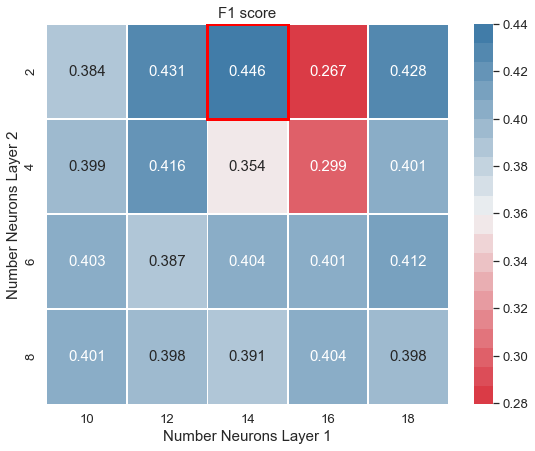

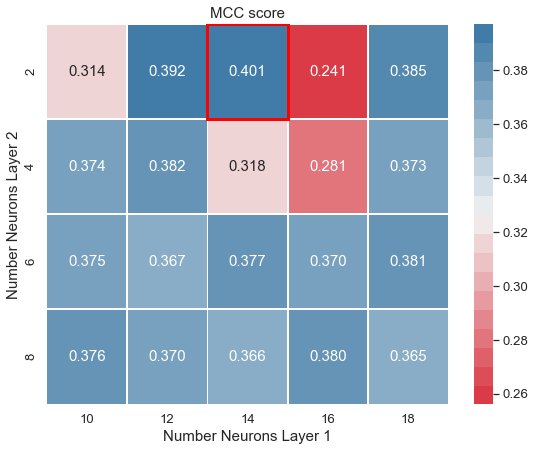

In [379]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Rectangle
import seaborn as sns

ax = plt.figure(figsize=(9,7)).gca()

#Plot all models' scores

heatmap_data = pd.pivot_table(results, values='mean_test_score', 
                     index=['param_kerasclassifier__n_neuronsL2'], 
                     columns='param_kerasclassifier__n_neuronsL1')
#midpoint = (heatmap_data.values.max() - heatmap_data.values.min()) / 2
#find best model during training
ind_max = np.unravel_index(np.argmax(heatmap_data, axis=None), heatmap_data.shape)

sns.set(font_scale=1.2) 
colormap = sns.diverging_palette(10, 240, n=20)
ax = sns.heatmap(heatmap_data, annot=True,cmap =colormap,linewidths=.5,fmt='.3f',annot_kws={"size":15},robust=True)
ax.add_patch(Rectangle((ind_max[1],ind_max[0]), 1, 1, fill=False, edgecolor='red', lw=3))

#sc = ax.scatter(results.param_kerasclassifier__n_neuronsL1, results.param_kerasclassifier__n_neuronsL2, s=200, c=results.mean_test_score, cmap='Greens', marker= 'x')

#ax.set_xticks(results.param_kerasclassifier__n_neuronsL1.tolist())
#ax.set_yticks(results.param_kerasclassifier__n_neuronsL2.tolist())

ax.set_xlabel("Number Neurons Layer 1",fontsize=15)
ax.set_ylabel("Number Neurons Layer 2",fontsize=15)
ax.set_title("F1 score",fontsize=15)
plt.show()



ax2 = plt.figure(figsize=(9,7)).gca()

#Plot all models' scores


heatmap_data = pd.pivot_table(results, values='mean_test_MCC', 
                     index=['param_kerasclassifier__n_neuronsL2'], 
                     columns='param_kerasclassifier__n_neuronsL1')
#midpoint = (heatmap_data.values.max() - heatmap_data.values.min()) / 2

ind_max = np.unravel_index(np.argmax(heatmap_data, axis=None), heatmap_data.shape)

sns.set(font_scale=1.2) 
colormap = sns.diverging_palette(10, 240, n=20)
ax2 = sns.heatmap(heatmap_data, annot=True,cmap =colormap,linewidths=.5,fmt='.3f',annot_kws={"size":15},robust=True)
ax2.add_patch(Rectangle((ind_max[1],ind_max[0]), 1, 1, fill=False, edgecolor='red', lw=3))

#sc = ax.scatter(results.param_kerasclassifier__n_neuronsL1, results.param_kerasclassifier__n_neuronsL2, s=200, c=results.mean_test_score, cmap='Greens', marker= 'x')

#ax.set_xticks(results.param_kerasclassifier__n_neuronsL1.tolist())
#ax.set_yticks(results.param_kerasclassifier__n_neuronsL2.tolist())

ax2.set_xlabel("Number Neurons Layer 1",fontsize=15)
ax2.set_ylabel("Number Neurons Layer 2",fontsize=15)
ax2.set_title("MCC score",fontsize=15)
plt.show()

# Testing Models

In [353]:
# For testing the model we use the complete training set to train again the models
# The training set is upsampled on a similar way as during gridsearch
from sklearn.utils import resample
#The minority class is always the positive class
majority_class = X_train[labelTrain==0].copy()
majority_class_labeled = majority_class.join(labelTrain[labelTrain==0])
minority_class = X_train[labelTrain==1].copy()
minority_class_labeled = minority_class.join(labelTrain[labelTrain==1])

# Upsample minority class
minority_upsampled = resample(minority_class_labeled, 
                                 replace=True,     # sample with replacement
                                 n_samples=11911,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
trainSet_upsampled = pd.concat([majority_class_labeled, minority_upsampled])
 
labels_upsampled = trainSet_upsampled.loc[:,labelName]
labels_upsampled.to_numpy()
features_upsampled = trainSet_upsampled.drop(labelName,axis=1).to_numpy()

In [359]:
from sklearn.metrics import plot_confusion_matrix,confusion_matrix, f1_score, classification_report, balanced_accuracy_score

resultsTest = []
global_results = pd.DataFrame()
#Iterate through the combinations of parameters to test the model on the testing set
#Requires to retrain the model for each parameter combination prior to testing

for neurons1 in neuronsL1:
    for neurons2 in neuronsL2:
        model = Sequential()
        model.add(Dense(neurons1, activation='relu', kernel_initializer='lecun_uniform',kernel_regularizer='l1',
                    input_shape=(n_features,)))
        model.add(Dropout(0.2))
        model.add(Dense(neurons2, activation='relu', kernel_initializer='lecun_uniform',kernel_regularizer='l1'))
        model.add(Dropout(0.2))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics='binary_accuracy')
        model.fit(features_upsampled, labels_upsampled, epochs=1000, batch_size= 500, initial_epoch=0, verbose=0)
        predictions = model.predict(X_test) > 0.5
        testingScore = f1_score(labelTest,predictions,average='binary')
        testingScore_mcc = matthews_corrcoef(labelTest,predictions)
        results_aux = dict(NeuronsLayer1=neurons1,NeuronsLayer2 = neurons2, TestingScore = testingScore,
                           TestingScoreMCC = testingScore_mcc)
        resultsTest.append(results_aux)
        print(results_aux)

C:\Users\joose\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


{'NeuronsLayer1': 10, 'NeuronsLayer2': 2, 'TestingScore': 0.0, 'TestingScoreMCC': 0.0}
{'NeuronsLayer1': 10, 'NeuronsLayer2': 4, 'TestingScore': 0.42463235294117646, 'TestingScoreMCC': 0.39842769146099494}
{'NeuronsLayer1': 10, 'NeuronsLayer2': 6, 'TestingScore': 0.3828793774319066, 'TestingScoreMCC': 0.3655371807296543}
{'NeuronsLayer1': 10, 'NeuronsLayer2': 8, 'TestingScore': 0.3890675241157556, 'TestingScoreMCC': 0.36929011802212836}
{'NeuronsLayer1': 12, 'NeuronsLayer2': 2, 'TestingScore': 0.4384694932781799, 'TestingScoreMCC': 0.40122710441984727}
{'NeuronsLayer1': 12, 'NeuronsLayer2': 4, 'TestingScore': 0.3408071748878923, 'TestingScoreMCC': 0.32016097173047725}
{'NeuronsLayer1': 12, 'NeuronsLayer2': 6, 'TestingScore': 0.401010951979781, 'TestingScoreMCC': 0.37895338308812815}
{'NeuronsLayer1': 12, 'NeuronsLayer2': 8, 'TestingScore': 0.38479809976247026, 'TestingScoreMCC': 0.36552312849504714}
{'NeuronsLayer1': 14, 'NeuronsLayer2': 2, 'TestingScore': 0.4329268292682927, 'TestingS

In [381]:
resultsTest= pd.DataFrame(resultsTest)

#global_results stores the scores during training and testing and calculates the mean of both scores
#The mean score is used to select the "best overall model"

global_results = resultsTest.copy()
global_results['TrainingScore'] = results.loc[:,'mean_test_score']
global_results['TrainingScoreMCC'] = results.loc[:,'mean_test_MCC']
col = global_results.loc[: , ["TrainingScore","TestingScore"]]
global_results['MeanScore'] = col.mean(axis=1)
col = global_results.loc[: , ["TrainingScoreMCC","TestingScoreMCC"]]
global_results['MeanScoreMCC'] = col.mean(axis=1)
global_results

#We find the best overall model (given by the maximum mean score bw training and testing)
best_overall_model = global_results[global_results.MeanScore==global_results.MeanScore.max()]
best_overall_model

best_overall_modelMCC = global_results[global_results.MeanScoreMCC==global_results.MeanScoreMCC.max()]
best_overall_modelMCC

,NeuronsLayer1,NeuronsLayer2,TestingScore,TestingScoreMCC,TrainingScore,TrainingScoreMCC,MeanScore,MeanScoreMCC
8,14,2,0.432927,0.396193,0.445868,0.40052,0.439397,0.398356


# Predictability plot

In [369]:
#Funtion to find the min and max score of both training and testing
#This is used to set the limits of the predictability plot axis
def findlimits(training_score,testing_score):
    min_training = training_score[training_score>0].min()
    min_testing = testing_score[testing_score>0].min()
    min_global = np.min([min_training,min_testing])-0.005 #Adding 0.005 offset so that markers do not appear on the edge of plot
    
    max_training = training_score.max()
    max_testing = testing_score.max()
    max_global = np.max([max_training,max_testing])+0.005 #Adding 0.005 offset so that markers do not appear on the edge of plot
    
    return [min_global,max_global]


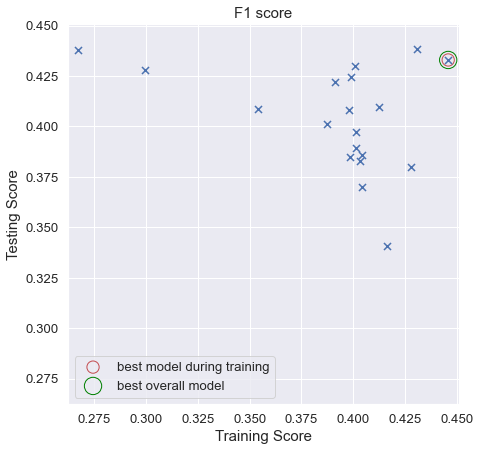

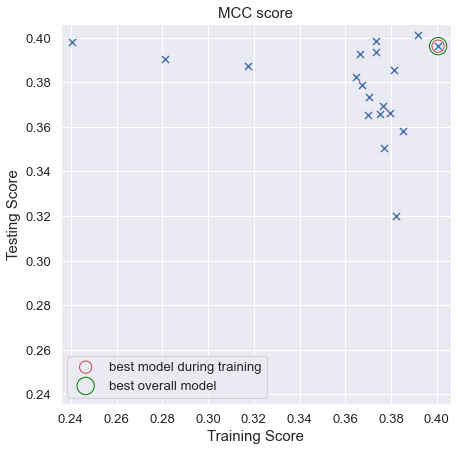

In [384]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

#We find the training score for the best model during trainning
best_training_result = results.mean_test_score.max()

#We find the testing score for the best model during training
testing_result = resultsTest.TestingScore[(resultsTest.NeuronsLayer1==Best_params['kerasclassifier__n_neuronsL1'])&
                                   (resultsTest.NeuronsLayer2==Best_params['kerasclassifier__n_neuronsL2'])]

ax = plt.figure(figsize=(7,7)).gca()

#We mark the result for the best model during training
ax.scatter(best_training_result,testing_result, s=150, marker= 'o',color='none',edgecolor='r',label='best model during training')

#We mark the result for the best overall model
ax.scatter(best_overall_model.TrainingScore,best_overall_model.TestingScore, s=300, marker= 'o',color='none',edgecolor='green',label='best overall model')

#We plot all the scores for all models
sc = ax.scatter(results.mean_test_score, resultsTest.TestingScore, s=50, marker= 'x',c='b')

ax.set_xlim(findlimits(results.mean_test_score, resultsTest.TestingScore))
ax.set_ylim(findlimits(results.mean_test_score, resultsTest.TestingScore))
ax.set_xlabel("Training Score",fontsize=15)
ax.set_ylabel("Testing Score",fontsize=15)
ax.set_title("F1 score",fontsize=15)
ax.legend()


## Ploting MCC score

#We find the training score for the best model during trainning
best_training_result = results.mean_test_MCC.max()

#We find the testing score for the best model during training
testing_result = global_results.TestingScoreMCC[global_results.TrainingScoreMCC ==best_training_result]

ax2 = plt.figure(figsize=(7,7)).gca()

#We mark the result for the best model during training
ax2.scatter(best_training_result,testing_result, s=150, marker= 'o',color='none',edgecolor='r',label='best model during training')

#We mark the result for the best overall model
ax2.scatter(best_overall_modelMCC.TrainingScoreMCC,best_overall_model.TestingScoreMCC, s=300, marker= 'o',color='none',edgecolor='green',label='best overall model')

#We plot all the scores for all models
sc = ax2.scatter(results.mean_test_MCC, resultsTest.TestingScoreMCC, s=50, marker= 'x',c='b')

ax2.set_xlim(findlimits(results.mean_test_MCC, resultsTest.TestingScoreMCC))
ax2.set_ylim(findlimits(results.mean_test_MCC, resultsTest.TestingScoreMCC))
ax2.set_xlabel("Training Score",fontsize=15)
ax2.set_ylabel("Testing Score",fontsize=15)
ax2.set_title("MCC score",fontsize=15)
ax2.legend()

# Testing best overall model

In [376]:
#Train and test again the best overall model to get the performance metrics
model = Sequential()
model.add(Dense(best_overall_model.NeuronsLayer1, activation='relu', kernel_initializer='lecun_uniform',kernel_regularizer='l1',
                input_shape=(n_features,)))
model.add(Dropout(0.2))
model.add(Dense(best_overall_model.NeuronsLayer2, activation='relu', kernel_initializer='lecun_uniform',kernel_regularizer='l1'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='binary_accuracy')

model.fit(features_upsampled, labels_upsampled,
              epochs=1000,
              batch_size=500,
              verbose=1)

Epoch 1/1000
49/49 [==============================] - 0s 1ms/step - loss: 1.7254 - binary_accuracy: 0.5031
Epoch 2/1000
49/49 [==============================] - 0s 1ms/step - loss: 1.2510 - binary_accuracy: 0.4873
Epoch 3/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.9404 - binary_accuracy: 0.4988
Epoch 4/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.7699 - binary_accuracy: 0.5056
Epoch 5/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.7192 - binary_accuracy: 0.5349
Epoch 6/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.7109 - binary_accuracy: 0.5562
Epoch 7/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.7040 - binary_accuracy: 0.5693
Epoch 8/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.7018 - binary_accuracy: 0.5769
Epoch 9/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6978 - binary_accuracy: 0.5813
Epoch 10/1000
49/49 [================

49/49 [==============================] - 0s 1ms/step - loss: 0.6472 - binary_accuracy: 0.6605
Epoch 77/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6407 - binary_accuracy: 0.6709
Epoch 78/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6374 - binary_accuracy: 0.6751
Epoch 79/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6443 - binary_accuracy: 0.6675
Epoch 80/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6430 - binary_accuracy: 0.6696
Epoch 81/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6370 - binary_accuracy: 0.6790
Epoch 82/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6416 - binary_accuracy: 0.6697
Epoch 83/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6396 - binary_accuracy: 0.6701
Epoch 84/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6403 - binary_accuracy: 0.6766
Epoch 85/1000
49/49 [=====================

49/49 [==============================] - 0s 1ms/step - loss: 0.6238 - binary_accuracy: 0.6856
Epoch 152/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6264 - binary_accuracy: 0.6827
Epoch 153/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6248 - binary_accuracy: 0.6836
Epoch 154/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6216 - binary_accuracy: 0.6896
Epoch 155/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6196 - binary_accuracy: 0.6918
Epoch 156/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6254 - binary_accuracy: 0.6835
Epoch 157/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6198 - binary_accuracy: 0.6869
Epoch 158/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6231 - binary_accuracy: 0.6860
Epoch 159/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6202 - binary_accuracy: 0.6899
Epoch 160/1000
49/49 [============

49/49 [==============================] - 0s 1ms/step - loss: 0.6170 - binary_accuracy: 0.6866
Epoch 227/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6172 - binary_accuracy: 0.6911
Epoch 228/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6145 - binary_accuracy: 0.6946
Epoch 229/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6195 - binary_accuracy: 0.6868
Epoch 230/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6178 - binary_accuracy: 0.6901
Epoch 231/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6193 - binary_accuracy: 0.6892
Epoch 232/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6185 - binary_accuracy: 0.6873
Epoch 233/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6165 - binary_accuracy: 0.6867
Epoch 234/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6142 - binary_accuracy: 0.6914
Epoch 235/1000
49/49 [============

49/49 [==============================] - 0s 1ms/step - loss: 0.6187 - binary_accuracy: 0.6846
Epoch 301/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6108 - binary_accuracy: 0.6957
Epoch 302/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6122 - binary_accuracy: 0.6933
Epoch 303/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6149 - binary_accuracy: 0.6907
Epoch 304/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6104 - binary_accuracy: 0.6968
Epoch 305/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6145 - binary_accuracy: 0.6905
Epoch 306/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6130 - binary_accuracy: 0.6896
Epoch 307/1000
49/49 [==============================] - 0s 997us/step - loss: 0.6144 - binary_accuracy: 0.6931
Epoch 308/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6149 - binary_accuracy: 0.6845
Epoch 309/1000
49/49 [==========

49/49 [==============================] - 0s 1ms/step - loss: 0.6081 - binary_accuracy: 0.6975
Epoch 376/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6152 - binary_accuracy: 0.6874
Epoch 377/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6098 - binary_accuracy: 0.6924
Epoch 378/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6171 - binary_accuracy: 0.6879
Epoch 379/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6081 - binary_accuracy: 0.6955
Epoch 380/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6150 - binary_accuracy: 0.6895
Epoch 381/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6135 - binary_accuracy: 0.6867
Epoch 382/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6125 - binary_accuracy: 0.6913
Epoch 383/1000
49/49 [==============================] - 0s 970us/step - loss: 0.6114 - binary_accuracy: 0.6881
Epoch 384/1000
49/49 [==========

Epoch 450/1000
49/49 [==============================] - 0s 997us/step - loss: 0.6095 - binary_accuracy: 0.6895
Epoch 451/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6119 - binary_accuracy: 0.6905
Epoch 452/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6105 - binary_accuracy: 0.6907
Epoch 453/1000
49/49 [==============================] - 0s 976us/step - loss: 0.6161 - binary_accuracy: 0.6879
Epoch 454/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6056 - binary_accuracy: 0.6963
Epoch 455/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6129 - binary_accuracy: 0.6885
Epoch 456/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6096 - binary_accuracy: 0.6906
Epoch 457/1000
49/49 [==============================] - 0s 997us/step - loss: 0.6115 - binary_accuracy: 0.6894
Epoch 458/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6191 - binary_accuracy: 0.6810
Epoch 459/100

49/49 [==============================] - 0s 1ms/step - loss: 0.6128 - binary_accuracy: 0.6880
Epoch 526/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6149 - binary_accuracy: 0.6893
Epoch 527/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6169 - binary_accuracy: 0.6826
Epoch 528/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6132 - binary_accuracy: 0.6880
Epoch 529/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6100 - binary_accuracy: 0.6894
Epoch 530/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6109 - binary_accuracy: 0.6928
Epoch 531/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6091 - binary_accuracy: 0.6895
Epoch 532/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6110 - binary_accuracy: 0.6841
Epoch 533/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6076 - binary_accuracy: 0.6932
Epoch 534/1000
49/49 [============

49/49 [==============================] - 0s 1ms/step - loss: 0.6046 - binary_accuracy: 0.6944
Epoch 600/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6085 - binary_accuracy: 0.6878
Epoch 601/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6122 - binary_accuracy: 0.6866
Epoch 602/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6148 - binary_accuracy: 0.6882
Epoch 603/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6084 - binary_accuracy: 0.6954
Epoch 604/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6090 - binary_accuracy: 0.6912
Epoch 605/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6093 - binary_accuracy: 0.6937
Epoch 606/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6080 - binary_accuracy: 0.6958
Epoch 607/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6115 - binary_accuracy: 0.6902
Epoch 608/1000
49/49 [============

49/49 [==============================] - 0s 1ms/step - loss: 0.6089 - binary_accuracy: 0.6885
Epoch 674/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6079 - binary_accuracy: 0.6924
Epoch 675/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6098 - binary_accuracy: 0.6881
Epoch 676/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6069 - binary_accuracy: 0.6938
Epoch 677/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6076 - binary_accuracy: 0.6942
Epoch 678/1000
49/49 [==============================] - ETA: 0s - loss: 0.6110 - binary_accuracy: 0.688 - 0s 1ms/step - loss: 0.6109 - binary_accuracy: 0.6886
Epoch 679/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6125 - binary_accuracy: 0.6868
Epoch 680/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6165 - binary_accuracy: 0.6824
Epoch 681/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6098 - binary_a

49/49 [==============================] - 0s 1ms/step - loss: 0.6064 - binary_accuracy: 0.6928
Epoch 748/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6103 - binary_accuracy: 0.6905
Epoch 749/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6090 - binary_accuracy: 0.6879
Epoch 750/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6064 - binary_accuracy: 0.6957
Epoch 751/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6117 - binary_accuracy: 0.6892
Epoch 752/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6107 - binary_accuracy: 0.6891
Epoch 753/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6121 - binary_accuracy: 0.6869
Epoch 754/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6082 - binary_accuracy: 0.6924
Epoch 755/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6092 - binary_accuracy: 0.6886
Epoch 756/1000
49/49 [============

49/49 [==============================] - 0s 1ms/step - loss: 0.6033 - binary_accuracy: 0.6961
Epoch 823/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6040 - binary_accuracy: 0.6951
Epoch 824/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6058 - binary_accuracy: 0.6953
Epoch 825/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6097 - binary_accuracy: 0.6893
Epoch 826/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6103 - binary_accuracy: 0.6875
Epoch 827/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6090 - binary_accuracy: 0.6910
Epoch 828/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6133 - binary_accuracy: 0.6882
Epoch 829/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6078 - binary_accuracy: 0.6939
Epoch 830/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6098 - binary_accuracy: 0.6898
Epoch 831/1000
49/49 [============

49/49 [==============================] - 0s 1ms/step - loss: 0.6041 - binary_accuracy: 0.6955
Epoch 898/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6027 - binary_accuracy: 0.6952
Epoch 899/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6084 - binary_accuracy: 0.6879
Epoch 900/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6038 - binary_accuracy: 0.6953
Epoch 901/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6059 - binary_accuracy: 0.6907
Epoch 902/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6052 - binary_accuracy: 0.6930
Epoch 903/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6088 - binary_accuracy: 0.6908
Epoch 904/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6174 - binary_accuracy: 0.6805
Epoch 905/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6120 - binary_accuracy: 0.6847
Epoch 906/1000
49/49 [============

49/49 [==============================] - 0s 1ms/step - loss: 0.6128 - binary_accuracy: 0.6861
Epoch 973/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6024 - binary_accuracy: 0.6918
Epoch 974/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6076 - binary_accuracy: 0.6904
Epoch 975/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6054 - binary_accuracy: 0.6934
Epoch 976/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6056 - binary_accuracy: 0.6915
Epoch 977/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6085 - binary_accuracy: 0.6925
Epoch 978/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6087 - binary_accuracy: 0.6907
Epoch 979/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6122 - binary_accuracy: 0.6879
Epoch 980/1000
49/49 [==============================] - 0s 1ms/step - loss: 0.6076 - binary_accuracy: 0.6918
Epoch 981/1000
49/49 [============

# Performance metrics for best model

0.43064985451018434


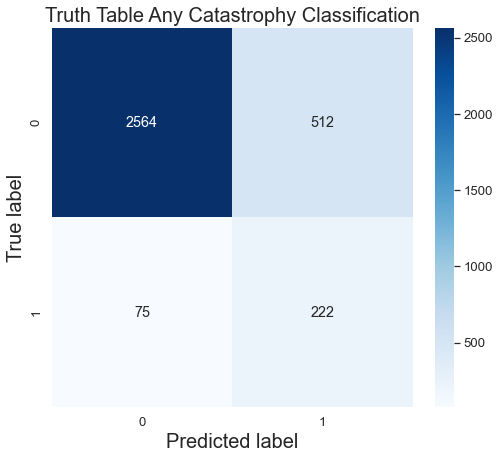

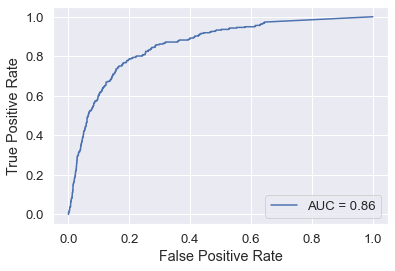

,precision,recall,f1-score,support
0,0.971580,0.833550,0.897288,3076.000000
1,0.302452,0.747475,0.430650,297.000000
accuracy,0.825971,0.825971,0.825971,0.825971
macro avg,0.637016,0.790512,0.663969,3373.000000
weighted avg,0.912662,0.825971,0.856199,3373.000000


In [377]:
from sklearn.metrics import plot_confusion_matrix,confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

#Predict the labels for testing set
predictions = (model.predict(X_test) > 0.5).astype("int32")

#Calculate f1 score and display
print(f1_score(labelTest,predictions,average='binary'))

#Calculate confusion matrix
confusionMatrix = confusion_matrix(labelTest,predictions)

figure = plt.figure(figsize=(7, 6))

sns.heatmap(confusionMatrix, annot=True,cmap='Blues',fmt='d')
plt.tight_layout()
plt.ylabel('True label',fontsize=20)
plt.xlabel('Predicted label',fontsize=20)
plt.title('Truth Table Any Catastrophy Classification',fontsize=20)
plt.show()

#Calculate performance metrics
report = classification_report(labelTest,predictions,output_dict=True)
report = pd.DataFrame(report).transpose()

#Calculate ROC based on prediction probabilities
predictions = model.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(labelTest, predictions)
roc_auc = metrics.auc(fpr, tpr)
display_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display_curve.plot()  
plt.show() 

report